# TESTS

### Imports

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Code from Contant Graspnet to visualize grasps with few modifications

In [5]:
import mayavi.mlab as mlab


def draw_grasps(grasps, cam_pose, gripper_openings, color=(0,1.,0), colors=None, show_gripper_mesh=False, tube_radius=0.0008):
    """
    Draws wireframe grasps from given camera pose and with given gripper openings

    Arguments:
        grasps {np.ndarray} -- Nx4x4 grasp pose transformations
        cam_pose {np.ndarray} -- 4x4 camera pose transformation
        gripper_openings {np.ndarray} -- Nx1 gripper openings

    Keyword Arguments:
        color {tuple} -- color of all grasps (default: {(0,1.,0)})
        colors {np.ndarray} -- Nx3 color of each grasp (default: {None})
        tube_radius {float} -- Radius of the grasp wireframes (default: {0.0008})
        show_gripper_mesh {bool} -- Renders the gripper mesh for one of the grasp poses (default: {False})
    """

#     gripper = mesh_utils.create_gripper('panda')
#     gripper_control_points = gripper.get_control_point_tensor(1, False, convex_hull=False).squeeze()
    gripper_control_points = np.array([[[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
                                        [ 5.2687433e-02, -5.9955313e-05,  5.8400001e-02],
                                        [-5.2687433e-02,  5.9955313e-05,  5.8400001e-02],
                                        [ 5.2687433e-02, -5.9955313e-05,  1.0527314e-01],
                                        [-5.2687433e-02,  5.9955313e-05,  1.0527314e-01]]], dtype=np.float32)
    gripper_control_points = gripper_control_points.squeeze()
    mid_point = 0.5*(gripper_control_points[1, :] + gripper_control_points[2, :])
    grasp_line_plot = np.array([np.zeros((3,)), mid_point, gripper_control_points[1], gripper_control_points[3], 
                                gripper_control_points[1], gripper_control_points[2], gripper_control_points[4]])

    if show_gripper_mesh and len(grasps) > 0:
        plot_mesh(gripper.hand, cam_pose, grasps[0])
        
    all_pts = []
    connections = []
    index = 0
    N = 7
    for i,(g,g_opening) in enumerate(zip(grasps, gripper_openings)):
        gripper_control_points_closed = grasp_line_plot.copy()
        gripper_control_points_closed[2:,0] = np.sign(grasp_line_plot[2:,0]) * g_opening/2
        
        pts = np.matmul(gripper_control_points_closed, g[:3, :3].T)
        pts += np.expand_dims(g[:3, 3], 0)
        pts_homog = np.concatenate((pts, np.ones((7, 1))),axis=1)
        pts = np.dot(pts_homog, cam_pose.T)[:,:3]
        
        color = color if colors is None else colors[i]
        
        all_pts.append(pts)
        connections.append(np.vstack([np.arange(index,   index + N - 1.5),
                                      np.arange(index + 1, index + N - .5)]).T)
        index += N
        # mlab.plot3d(pts[:, 0], pts[:, 1], pts[:, 2], color=color, tube_radius=tube_radius, opacity=1.0)
    
    # speeds up plot3d because only one vtk object
    all_pts = np.vstack(all_pts)
    connections = np.vstack(connections)
    src = mlab.pipeline.scalar_scatter(all_pts[:,0], all_pts[:,1], all_pts[:,2])
    src.mlab_source.dataset.lines = connections
    src.update()
    lines =mlab.pipeline.tube(src, tube_radius=tube_radius, tube_sides=12)
    mlab.pipeline.surface(lines, color=color, opacity=1.0)


def plot_coordinates(t,r, tube_radius=0.005):
    """
    plots coordinate frame

    Arguments:
        t {np.ndarray} -- translation vector
        r {np.ndarray} -- rotation matrix

    Keyword Arguments:
        tube_radius {float} -- radius of the plotted tubes (default: {0.005})
    """
    mlab.plot3d([t[0],t[0]+0.2*r[0,0]], [t[1],t[1]+0.2*r[1,0]], [t[2],t[2]+0.2*r[2,0]], color=(1,0,0), tube_radius=tube_radius, opacity=1)
    mlab.plot3d([t[0],t[0]+0.2*r[0,1]], [t[1],t[1]+0.2*r[1,1]], [t[2],t[2]+0.2*r[2,1]], color=(0,1,0), tube_radius=tube_radius, opacity=1)
    mlab.plot3d([t[0],t[0]+0.2*r[0,2]], [t[1],t[1]+0.2*r[1,2]], [t[2],t[2]+0.2*r[2,2]], color=(0,0,1), tube_radius=tube_radius, opacity=1)

def draw_pc_with_colors(pc, pc_colors=None, single_color=(0.3,0.3,0.3), mode='2dsquare', scale_factor=0.0018):
    """
    Draws colored point clouds

    Arguments:
        pc {np.ndarray} -- Nx3 point cloud
        pc_colors {np.ndarray} -- Nx3 point cloud colors

    Keyword Arguments:
        single_color {tuple} -- single color for point cloud (default: {(0.3,0.3,0.3)})
        mode {str} -- primitive type to plot (default: {'point'})
        scale_factor {float} -- Scale of primitives. Does not work for points. (default: {0.002})

    """

    if pc_colors is None:
        mlab.points3d(pc[:, 0], pc[:, 1], pc[:, 2], color=single_color, scale_factor=scale_factor, mode=mode)
    else:
        #create direct grid as 256**3 x 4 array 
        def create_8bit_rgb_lut():
            xl = np.mgrid[0:256, 0:256, 0:256]
            lut = np.vstack((xl[0].reshape(1, 256**3),
                                xl[1].reshape(1, 256**3),
                                xl[2].reshape(1, 256**3),
                                255 * np.ones((1, 256**3)))).T
            return lut.astype('int32')
        
        scalars = pc_colors[:,0]*256**2 + pc_colors[:,1]*256 + pc_colors[:,2]
        rgb_lut = create_8bit_rgb_lut()
        points_mlab = mlab.points3d(pc[:, 0], pc[:, 1], pc[:, 2], scalars, mode=mode, scale_factor=.0018)
        points_mlab.glyph.scale_mode = 'scale_by_vector'
        points_mlab.module_manager.scalar_lut_manager.lut._vtk_obj.SetTableRange(0, rgb_lut.shape[0])
        points_mlab.module_manager.scalar_lut_manager.lut.number_of_colors = rgb_lut.shape[0]
        points_mlab.module_manager.scalar_lut_manager.lut.table = rgb_lut

def visualize_grasps(full_pc, pred_grasps_cam, scores, plot_opencv_cam=False, pc_colors=None, gripper_openings=None, gripper_width=0.08):
    """Visualizes colored point cloud and predicted grasps. If given, colors grasps by segmap regions. 
    Thick grasp is most confident per segment. For scene point cloud predictions, colors grasps according to confidence.

    Arguments:
        full_pc {np.ndarray} -- Nx3 point cloud of the scene
        pred_grasps_cam {dict[int:np.ndarray]} -- Predicted 4x4 grasp trafos per segment or for whole point cloud
        scores {dict[int:np.ndarray]} -- Confidence scores for grasps

    Keyword Arguments:
        plot_opencv_cam {bool} -- plot camera coordinate frame (default: {False})
        pc_colors {np.ndarray} -- Nx3 point cloud colors (default: {None})
        gripper_openings {dict[int:np.ndarray]} -- Predicted grasp widths (default: {None})
        gripper_width {float} -- If gripper_openings is None, plot grasp widths (default: {0.008})
    """

    print('Visualizing...takes time')
    cm = plt.get_cmap('rainbow')
    cm2 = plt.get_cmap('gist_rainbow')
   
    fig = mlab.figure('Pred Grasps')
    mlab.view(azimuth=180, elevation=180, distance=0.2)
    draw_pc_with_colors(full_pc, pc_colors)
    colors = [cm(1. * i/len(pred_grasps_cam))[:3] for i in range(len(pred_grasps_cam))]
    colors2 = {k:cm2(0.5*np.max(scores[k]))[:3] for k in pred_grasps_cam if np.any(pred_grasps_cam[k])}
    
    if plot_opencv_cam:
        plot_coordinates(np.zeros(3,),np.eye(3,3))
    for i,k in enumerate(pred_grasps_cam):
        if np.any(pred_grasps_cam[k]):
            gripper_openings_k = np.ones(len(pred_grasps_cam[k]))*gripper_width if gripper_openings is None else gripper_openings[k]
            if len(pred_grasps_cam) > 1:
                draw_grasps(pred_grasps_cam[k], np.eye(4), color=colors[i], gripper_openings=gripper_openings_k)    
                draw_grasps([pred_grasps_cam[k][np.argmax(scores[k])]], np.eye(4), color=colors2[k], 
                            gripper_openings=[gripper_openings_k[np.argmax(scores[k])]], tube_radius=0.0025)    
            else:
                colors3 = [cm2(0.5*score)[:3] for score in scores[k]]
                draw_grasps(pred_grasps_cam[k], np.eye(4), colors=colors3, gripper_openings=gripper_openings_k)    
    mlab.show()

Failed to establish dbus connection

### Load masks from detectron

In [6]:
mask_cucumber = cv2.imread("/home/avena/Dropbox/DETECTRON/New_masks_for_tests/mask_1.png")
mask_cucumber = cv2.cvtColor(mask_cucumber, cv2.COLOR_BGR2GRAY)
mask_banana = cv2.imread("/home/avena/Dropbox/DETECTRON/New_masks_for_tests/mask_0.png")
mask_banana = cv2.cvtColor(mask_banana, cv2.COLOR_BGR2GRAY)

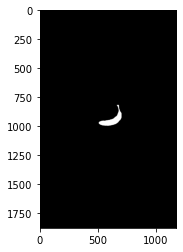

In [7]:
plt.imshow(mask_banana, cmap='gray')

### Load ortho rgb and ortho depth

In [8]:
points = cv2.imread("/home/avena/vision3/1642671173613223239_depth.png", cv2.IMREAD_UNCHANGED)
rgb = cv2.imread("/home/avena/vision3/1642671173613223239_color.png")
rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)

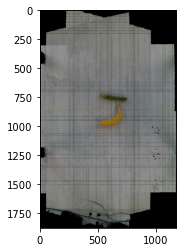

In [9]:
plt.imshow(rgb)

In [10]:
points.shape

(1875, 1176)

### Make point cloud from ortho

In [12]:
scale_factor = 80 / 100

points_array_trim = []

colors_array_trim = []


for y in range(points.shape[0]):
    for x in range(points.shape[1]):
        if points[y, x] == 0:
            continue
        
        points_array_trim.append([x / 1000 * scale_factor,
                                  y / 1000 * scale_factor,
                                  points[y, x] / 1000 * scale_factor])
        colors_array_trim.append(rgb[y, x, :])
        
points_array_trim = np.array(points_array_trim)
colors_array_trim = np.array(colors_array_trim)   

### Prepare data for ContantGraspnet

In [13]:
final_data = {"xyz": points_array_trim, "xyz_color": colors_array_trim}

### Save data

In [14]:
with open("/home/avena/vision3/final_data.npy", "wb") as f:
    np.save(f, final_data)

### Load grasps and scores from Contact Graspnet

In [15]:
with np.load('/home/avena/software/contact_graspnet/results/predictions_final_data.npz', allow_pickle=True) as data:
#     grasps = list(data['pred_grasps_cam'].item().values())[0]
    grasps = data['pred_grasps_cam'].item()
#     scores = list(data['scores'].item().values())[0]
    scores = data['scores'].item()


### Show all grasps

In [41]:
visualize_grasps(points_array_trim, grasps, scores, plot_opencv_cam=True, pc_colors=colors_array_trim)

Visualizing...takes time


## This is function for filtering grasps

In [37]:
def filter_grasps(grasps, scores, mask, mask_filter_policy=1, final_filter_policy=1, scale_factor=0.8):
    """
    This function returns one best grasp, for given object. Filtration is done based on various policies, 
    which might be chosen by the user.
    
    First step is to filter all grasps outside the mask. There are few ways to bound mask region.
        1. Contours
        2. Rotated Bounding Box
        3. Axis Aligned Bouding Box
    They are listed from the most restrictive to the most liberative.
    User can set mask_filter)policy, to decide which policy to use.
    
    Second step is to get best grasp from legal ones. There two options:
        1. Grasp closest to the center point of region,
        2. Grasp with highest confidence score.
    User can choose policy be setting final_filter_policy.
    
    
    :param grasps Dict of predicted grasps from Contact Graspnet. Key must be -1
    :param scores Dict of scores for each grasp from Contant Graspnet. Key must be -1
    :param mask Binary segmentation mask, in orthoview
    :param mask_filter_policy parameter which can choosen from 1, 2 or 3 to set the mask filtering policy. Default 1
    :param final_filter_policy parameter which can choosen from 1 or 2 to set the final filtering policy. Default 1
    :param scale_factor Float describing how much point cloud was squeezed for interference from Contact Graspnet
    
    :returns Dict which key is -1 and value is best grasp, based on chosen policies.
    """
    if mask_filter_policy < 1 or mask_filter_policy > 3:
        raise ValueError("Mask filter policy must be from range 1-3")
    if final_filter_policy < 1 or final_filter_policy > 2:
        raise ValueError("Final filter polocy must be from range 1-2")
    
    assert len(grasps) == len(scores), "Grasp and scores must be of same size"
    assert len(mask.shape) == 2, "Mask must be of binary format"
    
    # Compute contours of a mask
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    assert len(contours) == 1, "More than 1 contour detected, please check if mask is consistent"
    contours = contours[0].reshape(-1, 2)
    
    # 1. Contours
    if mask_filter_policy == 1:
        allowed_area = contours
        
    # 2. Rotated Bounding Box
    elif mask_filter_policy == 2:
        
        min_area_rect = cv2.minAreaRect(contours)
        rotatedBB = cv2.boxPoints(min_area_rect)
        allowed_area = np.intp(rotatedBB)
        
    # 3. Axis Aligned Bounding Box
    elif mask_filter_policy == 3:
        *corner, w, h = cv2.boundingRect(mask)
        bounding_box_points = [corner, 
                              [corner[0] + w, corner[1]],
                              [corner[0] + w, corner[1] + h], 
                              [corner[0], corner[1] + h]]
        allowed_area = np.array(bounding_box_points)
        
    # We are operating on orthoview. It means that X and Y in pointcloud 
    # corespond to pixel position in the mask image. Thus, we can compare points in point cloud
    # to area in mask image.
    
    # make list that will be storing legal grasps
    allowed_grasps_indices = []
    
    # get grasps and scores arrays, because they are stored in dict.
    grasps = grasps[-1]
    scores = scores[-1]
    
    # iterate over all grasps
    for i, grasp in enumerate(grasps):
        # multiply points times 1000, to get back from mm to pixels
        grasp_point = (int(grasp[0][3] * 1000 * (1 / scale_factor)), int(grasp[1][3] * 1000 * (1 / scale_factor)))
        # check if X Y of grasp is inside legal area
        valid = cv2.pointPolygonTest(allowed_area, grasp_point, measureDist=False)
        # add grasp to list of legal if valid is non-negative. It means that grasp is inside the region.
        if valid >= 0:
            allowed_grasps_indices.append(i)
    # get the legal grasps by indicies
    legal_grasps = grasps[allowed_grasps_indices]
    legal_grasps_scores = scores[allowed_grasps_indices]
    
    
    # Final filter policy implements two solutions:
    # 1. Compute the middle point of allowed area and get grasp which is the closes to the middle point
    # 2. Get the grasp with the biggest confidence score
    
    if final_filter_policy == 1:
        
        # Compute middle point of the mask
        M = cv2.moments(contours)
        cx = round(M['m10'] / M['m00'])
        cy = round(M['m01'] / M['m00'])
        
        # Compute distance for each grasp
        distance = []
        for legal_grasp in legal_grasps:
            d = np.linalg.norm(np.array([cx, cy]) - np.array([int(legal_grasp[0][3] * 1000 * (1 / scale_factor)), int(legal_grasp[1][3] * 1000 * (1 / scale_factor))]))
            distance.append(d)
        
        # Get ID of minimum distance
        best_grasp_idx = distance.index(min(distance))
    
    if final_filter_policy == 2:
        # Get the biggest confidence score 
        legal_grasps_scores = list(legal_grasps_scores)
        best_grasp_idx = legal_grasps_scores.index(max(legal_grasps_scores))
        
    # go back to dict, for visualization
    return {-1: [legal_grasps[best_grasp_idx]]}

In [40]:
visualize_grasps(points_array_trim, 
                 filter_grasps(grasps, scores, mask_banana, mask_filter_policy=1, final_filter_policy=2, scale_factor=0.8), 
                 scores, plot_opencv_cam=True, 
                 pc_colors=colors_array_trim)

Visualizing...takes time
